# Tutorials

In this notebook, we will walk through different ways of uploading data to the database, namely

- uploading a DESC equilibrium directly from Python interface

- uploading a DESC output file directly from Python interface

- creating required csv files and using the website

First of all, let's import required functions. If you don't have `stelladb` package yet, you can install it using `pip install stelladb`. You might want to install this package to a new conda environment since it will install DESC and SIMSOPT as dependencies, so that your local DESC/SIMSOPT doesn't interfere with the new ones. To create a new conda environment, simply you need to type,

```bash
conda create --name db 'python>=3.9, <=3.12'
conda activate db
pip install stelladb
```

Now, you should be able to import following functions,

In [1]:
# if you are using the repository, you should use the following import
# and chnage your absolute path to the repository path
import os
import sys

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../"))

from stelladb import save_to_db_desc
from desc.examples import get

DESC version 0.11.1,using JAX backend, jax version=0.4.26, jaxlib version=0.4.26, dtype=float64
Using device: CPU, with 9.81 GB available memory


## Upload a DESC equilibrium directly from Python interface

For convenience, we will use example equilibrium included in DESC library. Notice that database will not allow duplicate result names, so when you run this notebook, you will probably get errors. We will explain the errors too. Due to small numerical tolerances, we cannot make check on the server-side to detect duplicate entries, instead we expect users not to upload same data multiple times. Let's get the `HELIOTRON` equilibrium, and upload it to the database.

Zipping files...
Saving equilibrium to .h5 file...
Creating desc_runs.csv and configurations.csv...
Plotting/saving surface, Boozer and 3D plots...
Uploading to database...

Configuration data successfully uploaded.
Your data is stored in `configurations` table with name: tutorial_HELIOTRON
DESC data successfully uploaded.
Your data is stored in `desc_runs` table with id: 329
The file tutorial_HELIOTRON.zip has been uploaded as desc_329_tutorial_HELIOTRON.zip
The file tutorial_HELIOTRON_surface.webp has been uploaded as surface_desc_329_tutorial_HELIOTRON.webp
The file tutorial_HELIOTRON_boozer.webp has been uploaded as boozer_desc_329_tutorial_HELIOTRON.webp
The file tutorial_HELIOTRON_3d.html has been uploaded as plot3d_desc_329_tutorial_HELIOTRON.html


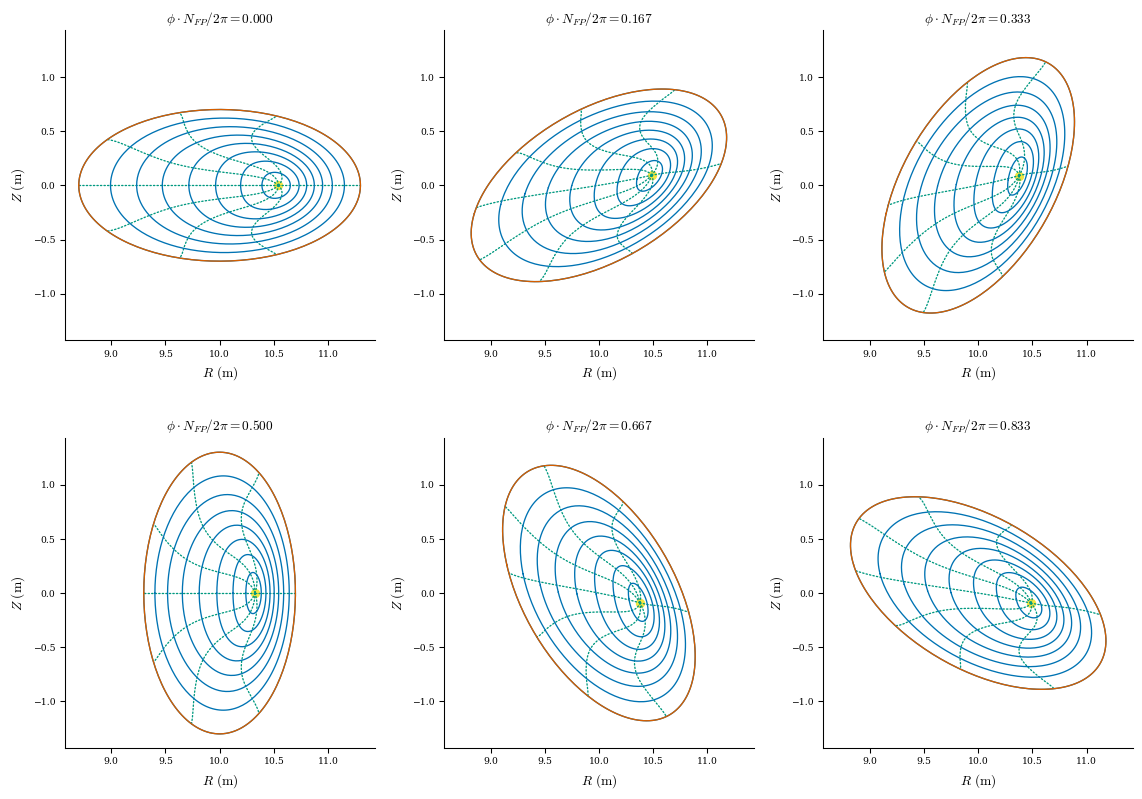

In [2]:
# create the equilibrium object
eq = get('HELIOTRON')

# upload to the equilibrium to database with plots
save_to_db_desc(eq, config_name='tutorial_HELIOTRON', user='test-user-id', uploadPlots=True)

# upload to the equilibrium to database without plots
# save_to_db_desc(eq, config_name='tutorial_HELIOTRON', user='test-user-id')

In addition to 3 required parameters, you can also specify optional data.

- `uploadPlots` parameter is used to create flux surface, Boozer and 3D plots of the equilibrium and save it to the database. Since it slows down the uploading procedure, by default it is set to `False`, but if you have enough time we highly suggest to set this parameter to `True`.

- `inputfile` parameter is basically a boolean which has default value of `False`. If you set it to `True`, an inputfile will be generated automatically using DESC's `desc_output_to_input` function if a valid `inputfilename` is not given. You can also just give a valid `inputfilename` and don't specify `inputfile` paramater. 

- `description` parameter is the short description of the simulation. It should be a string.

- `provenance` parameter is a short explanation of where the configuration came from.

- `deviceid` parameter is the name of the device this simulation is used for. If the user wants set `deviceid` either that device should already exist in the database with that unique name or user can upload the information on the device while uploading simulation data. Latter requires following parameters to be given too.

    - `isDeviceNew` parameter must be set to `True` if the user creates the first entry for that device. Defaults to `False`.

    - `deviceNFP` parameter is for the number of field periods for the device.

    - `deviceDescription` parameter is the short description of the device.

    - `device_stell_sym` parameter is the stellarator symmetry of the device. `True` with stellarator symmetry, `False` otherwise.

- `inputfilename` stores the name of the input file corresponding to this configuration. If the user supplies a valid `inputfilename`, the API will automatically set `inputfile` to `True` and upload the input file to the database. If the file path is invalid, it will not be uploaded.

- `config_class` is the class of configuration i.e. quasisymmetry (QA, QH, QP) or omnigenity (QI, OT, OH) or axisymmetry (AS).

- `initialization_method` parameter is for the method used to initialize the equilibrium. The default value is `surface` but it can also be set to `axis`. Once the Poincare surface boundary condition capability merged into DESC master branch, `poincare` will also be one of the available options.

- `copy` parameter is used to specify if the zip and csv files should be kept after uploading on user's local files. The default value is `False` such that all the files created by the function will be deleted (i.e. auto-generated inputfile, zip file and csv files).

## Uploading a DESC output file directly from Python interface

Again, from DESC examples, we will use the `ARIES-CS` equilibrium. First, save that equilibrium in h5 output format. Or in practical case, you already have an h5 file. Then, upload it to the database.

In [3]:
# save the equilibrium with given name
eq.save('tutorial_ARIES-CS.h5')
# upload to the equilibrium to database
save_to_db_desc('tutorial_ARIES-CS', config_name='tutorial_ARIES-CS', user='test-user-id', uploadPlots=True)

Zipping files...
Creating desc_runs.csv and configurations.csv...
Uploading to database...

Configuration data successfully uploaded.
Your data is stored in `configurations` table with name: tutorial_ARIES-CS
DESC data successfully uploaded.
Your data is stored in `desc_runs` table with id: 212
The file tutorial_ARIES-CS.zip has been uploaded as desc_212_tutorial_ARIES-CS.zip


## Creating required csv files and using the website

Previous two methods assume that the user have installed `Google Chrome`, `Safari`, `Firefox` or `Edge` on their computer. If you don't have any (i.e. some clusters or WSL) or for some other reason you need to upload through website manually, you can follow these steps. First, you need to create `desc_runs.csv` and `configurations.csv` files using `desc_to_csv` function.

In [ ]:
from stelladb.db_desc import desc_to_csv

desc_to_csv(
    eq, 
    name="tutorial_Heliotron", 
    provenance="DESC examples",
    description="HELIOTRON equilibrium",
    user_updated="test-user-id",
    user_created="test-user-id",
)

If you don't want to create a new device for this equilibrium (i.e. some experimental device W7-X, ATF or LHD), you can zip the output, input (if you have any) and python script you used, and go to the database [website](https://ye2698.mycpanel.princeton.edu/). On import page, you can select generated files and press confirm. However, if you want to add a new device too, first use `device_or_concept_to_csv` function, and in the website, select the `devices_and_concepts.csv` file too.

In [ ]:
from stelladb.device import device_or_concept_to_csv

device_or_concept_to_csv(
    deviceid="ShortDeviceName",
    name="The full name of the device",
    device_class="QA",
    NFP=4,
    description="Some description",
    stell_sym=True,
    user_created="test-user-id",
    user_updated="test-user-id",
)